In [1]:
import pandas as pd
from datetime import datetime, timedelta
from pandas import Index
import numpy as np

In [4]:
pm25=pd.read_csv("data/hour/airparca_merceillie_2018070720180805_pm25_h.csv",sep=';')

In [5]:
pm25.head()

,Station,Polluant,Mesure,Unité,07/07/2018 0:00,07/07/2018 1:00,07/07/2018 2:00,07/07/2018 3:00,07/07/2018 4:00,07/07/2018 5:00,...,05/08/2018 15:00,05/08/2018 16:00,05/08/2018 17:00,05/08/2018 18:00,05/08/2018 19:00,05/08/2018 20:00,05/08/2018 21:00,05/08/2018 22:00,05/08/2018 23:00,06/08/2018 0:00
0,Marseille-Longchamp,"Particules PM2,5",Particules PM2.5,µg/m³,8,11,10,13,11,9,...,15,13,12,13,10,8,10,-,-,-


In [7]:
parca_table=pm25.drop(columns=['Polluant','Mesure','Unité'])

In [8]:
parca_table=parca_table.set_index(parca_table['Station']).drop(columns='Station').transpose()
parca_table.columns.name="date"
def converttype(v):
    if v =='-':
        return None
    else:
        return int(v)

In [9]:
parca_table=parca_table.applymap(converttype)

In [12]:
parca_table.to_csv("output/parcapm25.csv")

In [17]:
parca_table.reset_index(inplace=True)

In [23]:
parca_table.columns = Index(['date time', 'Marseille-Longchamp'], dtype='object', name='index')

In [25]:
parca_table['date time']=list(map(lambda string: str(datetime.strptime(string,'%d/%m/%Y %H:%M')+timedelta(hours=6)),parca_table['date time']))

In [26]:
parca_table.head()

index,date time,Marseille-Longchamp
0,2018-07-07 06:00:00,8.0
1,2018-07-07 07:00:00,11.0
2,2018-07-07 08:00:00,10.0
3,2018-07-07 09:00:00,13.0
4,2018-07-07 10:00:00,11.0


In [13]:
trend=pd.read_csv("data/hour/ggtrend2018072920180805_alpes_airpollution_h.csv")
trend=trend.reset_index().drop(0,axis=0)
trend.columns=Index(['date time', 'air pollution'], dtype='object')
# because google trend gives us the local time. Our machine use EST time that is 6 hours behind the local time of paris
trend['date time']=list(map(lambda string: str(datetime.strptime(string,'%Y-%m-%dT%H')+timedelta(hours=6)),trend['date time']))

In [14]:
trend.to_csv("output/googletrend_airtopic_parca.csv",index=False)

In [21]:
trend.head()

,date time,air pollution
1,2018-07-29 22:00:00,0
2,2018-07-29 23:00:00,15
3,2018-07-30 00:00:00,0
4,2018-07-30 01:00:00,0
5,2018-07-30 02:00:00,26


In [28]:
merged_t=parca_table.merge(trend,left_on='date time',right_on='date time')

In [32]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df

In [49]:
merged_t['air pollution']=merged_t['air pollution'].astype(np.float)

In [50]:
cross_correlation=merged_t[['Marseille-Longchamp','air pollution']]

In [51]:
new_cross=df_derived_by_shift(cross_correlation,lag=6)

In [52]:
new_cross = new_cross.dropna()

In [53]:
new_cross.head(10)

,Marseille-Longchamp,air pollution,Marseille-Longchamp_1,Marseille-Longchamp_2,Marseille-Longchamp_3,Marseille-Longchamp_4,Marseille-Longchamp_5,Marseille-Longchamp_6,air pollution_1,air pollution_2,air pollution_3,air pollution_4,air pollution_5,air pollution_6
6,11.0,0.0,10.0,10.0,9.0,9.0,9.0,9.0,0.0,26.0,0.0,0.0,15.0,0.0
7,11.0,41.0,11.0,10.0,10.0,9.0,9.0,9.0,0.0,0.0,26.0,0.0,0.0,15.0
8,10.0,18.0,11.0,11.0,10.0,10.0,9.0,9.0,41.0,0.0,0.0,26.0,0.0,0.0
9,16.0,9.0,10.0,11.0,11.0,10.0,10.0,9.0,18.0,41.0,0.0,0.0,26.0,0.0
10,16.0,5.0,16.0,10.0,11.0,11.0,10.0,10.0,9.0,18.0,41.0,0.0,0.0,26.0
11,14.0,4.0,16.0,16.0,10.0,11.0,11.0,10.0,5.0,9.0,18.0,41.0,0.0,0.0
12,21.0,16.0,14.0,16.0,16.0,10.0,11.0,11.0,4.0,5.0,9.0,18.0,41.0,0.0
13,12.0,15.0,21.0,14.0,16.0,16.0,10.0,11.0,16.0,4.0,5.0,9.0,18.0,41.0
14,13.0,7.0,12.0,21.0,14.0,16.0,16.0,10.0,15.0,16.0,4.0,5.0,9.0,18.0
15,13.0,22.0,13.0,12.0,21.0,14.0,16.0,16.0,7.0,15.0,16.0,4.0,5.0,9.0


In [54]:
new_cross.corr()

,Marseille-Longchamp,air pollution,Marseille-Longchamp_1,Marseille-Longchamp_2,Marseille-Longchamp_3,Marseille-Longchamp_4,Marseille-Longchamp_5,Marseille-Longchamp_6,air pollution_1,air pollution_2,air pollution_3,air pollution_4,air pollution_5,air pollution_6
Marseille-Longchamp,1.000000,-0.080608,0.735064,0.542385,0.372833,0.216803,0.167547,0.060161,-0.098894,-0.023025,0.027366,0.019752,0.020567,-0.108038
air pollution,-0.080608,1.000000,-0.022616,0.049616,-0.027719,-0.101146,-0.145991,-0.080564,0.038587,-0.010985,-0.017557,-0.033585,-0.007328,-0.029746
Marseille-Longchamp_1,0.735064,-0.022616,1.000000,0.739699,0.553239,0.386452,0.233652,0.183810,-0.071838,-0.110890,-0.015018,0.034838,0.014744,0.027300
Marseille-Longchamp_2,0.542385,0.049616,0.739699,1.000000,0.745224,0.561827,0.398110,0.247424,-0.016006,-0.083948,-0.102741,-0.007810,0.030875,0.023191
Marseille-Longchamp_3,0.372833,-0.027719,0.553239,0.745224,1.000000,0.749795,0.568959,0.409988,0.053942,-0.031265,-0.075614,-0.094239,-0.010125,0.044181
Marseille-Longchamp_4,0.216803,-0.101146,0.386452,0.561827,0.749795,1.000000,0.753978,0.577474,-0.022736,0.037873,-0.023581,-0.067498,-0.095787,0.003349
Marseille-Longchamp_5,0.167547,-0.145991,0.233652,0.398110,0.568959,0.753978,1.000000,0.759497,-0.097347,-0.037533,0.044289,-0.016693,-0.068332,-0.080190
Marseille-Longchamp_6,0.060161,-0.080564,0.183810,0.247424,0.409988,0.577474,0.759497,1.000000,-0.138319,-0.110912,-0.029328,0.051518,-0.019946,-0.056377
air pollution_1,-0.098894,0.038587,-0.071838,-0.016006,0.053942,-0.022736,-0.097347,-0.138319,1.000000,0.032509,-0.008770,-0.015335,-0.033227,-0.000009
air pollution_2,-0.023025,-0.010985,-0.110890,-0.083948,-0.031265,0.037873,-0.037533,-0.110912,0.032509,1.000000,0.026272,-0.014692,-0.011806,-0.039308


In [55]:
df_new =new_cross

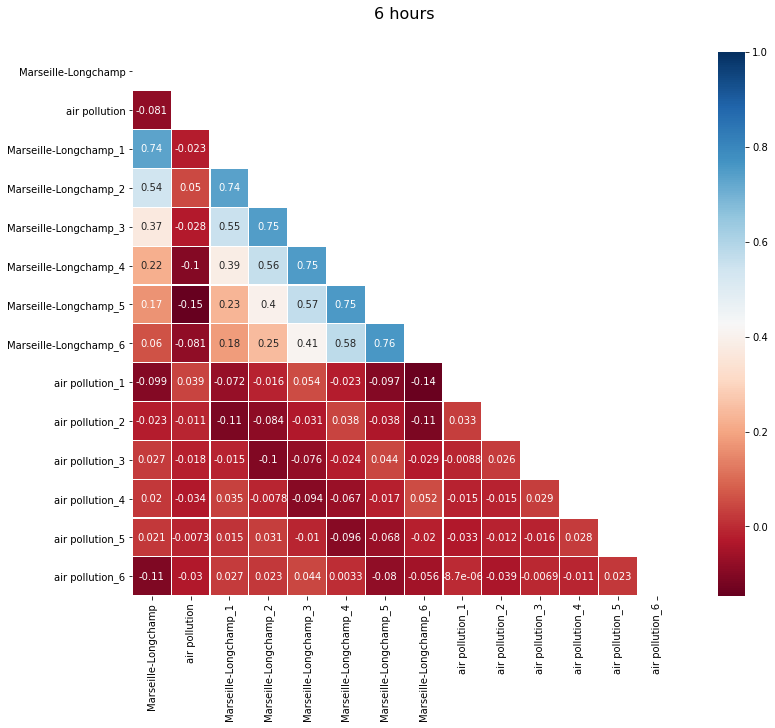

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(15,10))
plt.title(u'6 hours', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)